# 8. Bidirectional RNNs

In [1]:
import torch 
import torch.nn as nn
from torch.utils import data
from torch.nn import functional as F

import re
import collections

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from d2l import torch as d2l

Previously, in sequence learning tasks, we aim to predict the **next token** given all **privious tokens** in a sequence.

However, sometimes the **rightward context** matters as much as the **leftward context**, for example:

- I am ___.
- I am ___ hungry.
- I am ___ hungry, and I can eat half a pig.

The missing token depends largely on the context in **both directions**.

## Dynamic Programming in HMM

Consider a **hidden Markov model** (HMM) where $x_t$ is given by $P(x_t \mid h_t)$ and $h_{t+1}$ is given by $P(h_{t+1} \mid h_{t})$:

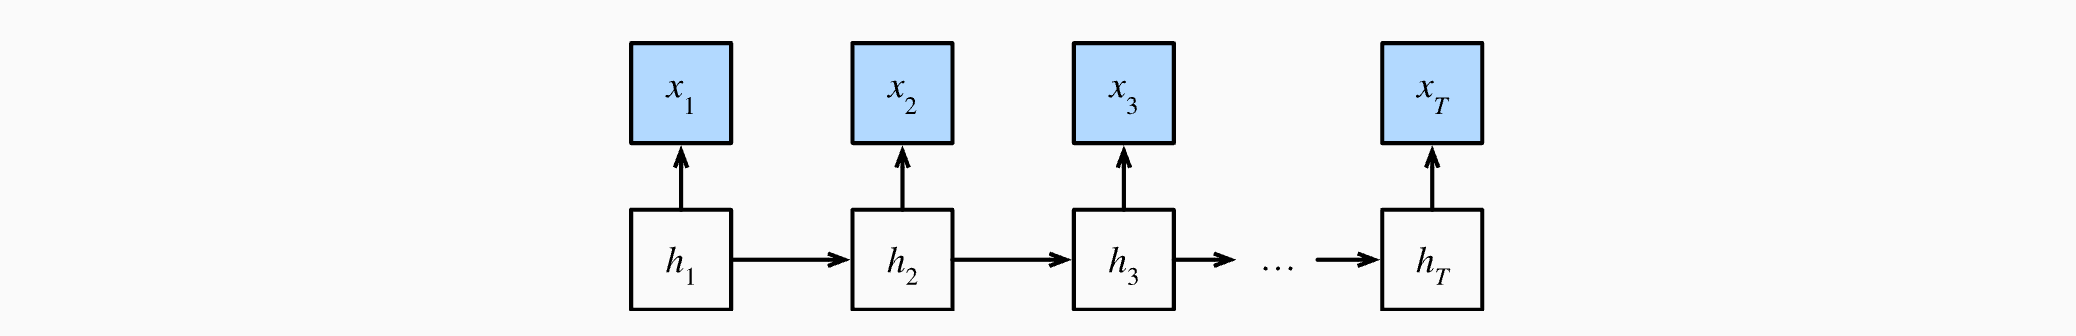

Therefore, for a sequence with **$T$ observations**, we have the following **joint probability**:

$$P(x_1, \ldots, x_T, h_1, \ldots, h_T) = \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t), \text{ where } P(h_1 \mid h_0) = P(h_1)$$

Now, we would like to **compute $P(x_j \mid x_{-j})$** where we observe all $x_{-j} = (x_1, \ldots, x_{j-1}, x_{j+1}, \ldots, x_{T})$. 

......mathematically heavy stuff.....

## Bidirectional Model

To take the rightward context into account, we can simply implement **2 unidirectional RNN layers** chained together in **opposite directions** and acting on the **same input**.

Such design is the same as the **forward recursion** and **backward recursion** in a **hidden Markov model**.

![](http://d2l.ai/_images/birnn.svg)

For the first RNN layer, the **first input** is $x_1$ and the **last input** is $x_T$. For the second RNN layer, the **first input** is $x_T$ and the **last input** is $x_1$. 

To produce the **output** of this bidirectional RNN layer, we simply **concatenate** together the corresponding outputs of the two underlying unidirectional RNN layers.

## Definitions

For any time stepo $t$, given a **mini-batch input** $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ and the **activation** $\phi$ for the hidden layers, we have the **forward and backward hidden states** $\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ and $\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ are as following:

$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)})\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)})
\end{aligned}
$$

where $\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{h \times h}$ are the **weights** and $\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h}, \mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$ are the **bias**.

Then, the **output** of this bidirectional layer $\mathbf{O}_t \in \mathbb{R}^{n \times q}$ is given as:

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q$$

where the **hidden state** $\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$ of the output layer is obtained by **concatenating** $\overrightarrow{\mathbf{H}}_t$ and $\overleftarrow{\mathbf{H}}_t$.

## Computational Cost

However, a **bidirectional model** uses both the leftward and rightward context in making predictions. Such strategy works in **training** but fails when applied to **test data** since we are not able to know the **future (rightward context)**.

Moerover, bidirectional models are very **inefficient** in terms of computational speed. This is because that both **forward and backward recursion** must be carried out in **forward propagation**. Therefore, there exists a **very long chain** when computing the gradients using **backpropagtion**.

## Implementation (Bad Example)

A bidirectional model might achieve great perplexity scores in training but will perform badly in practice:

In [ ]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size

lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)

model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)